In [ ]:
from matplotlib import pyplot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Flatten,
    Input,
    Reshape,
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def convert_to_grayscale(images):
    """
    Convert RGB images to grayscale.
    Multiply indeces are stands for "@"TU-R Recommendation BT.601", corresponding to the human perception of color.
    """
    return np.dot(images[..., :3], [0.2989, 0.5870, 0.1140]) # .astype(np.float32)

Images in Cifar10 dataset are represented as a set of images with 32*32 size with 3 RGB color channels.

Each image can be represented as a tensor with size (32,32,3).

In order to colorization task we need to put a grayscale image (32, 32, 1) into model input.

**x_train** - initial colored train dataset

**x_test** - initial colored test dataset

**x_train_gray** - grayscale train dataset

**x_test_gray** - grayscale test dataset

In [2]:
# ---------- Prepare data section ---------- #
# load cifar10 color dataset
# x_train, y_train - training dataset and validation vector
(x_train, _), (x_test, _) = cifar10.load_data()

# convert to float32 and normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_gray = convert_to_grayscale(x_train)
x_test_gray = convert_to_grayscale(x_test)

# input image dimensions
image_rows = x_train.shape[1]
image_cols = x_train.shape[2]
channels = x_train.shape[3]


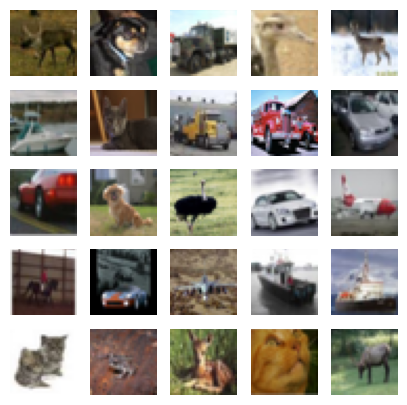

In [3]:
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
# plot the 25 cifar images
pyplot.figure(figsize=(5,5))
for i in range(len(indexes)):
    pyplot.subplot(5, 5, i + 1)
    image = images[i]
    pyplot.imshow(image, cmap='gray')
    pyplot.axis('off')
pyplot.savefig('train-samples.png')
pyplot.show()
pyplot.close('all')

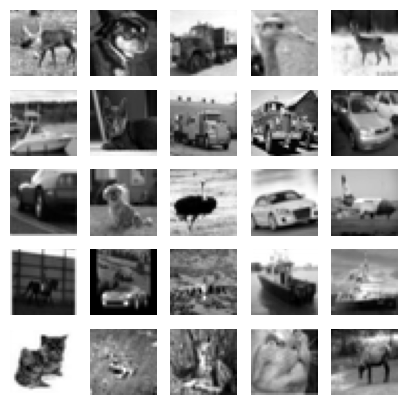

In [4]:
images = x_train_gray[indexes]
# plot the 25 cifar images in grayscale
pyplot.figure(figsize=(5,5))
for i in range(len(indexes)):
    pyplot.subplot(5, 5, i + 1)
    image = images[i]
    pyplot.imshow(image, cmap='gray')
    pyplot.axis('off')
pyplot.savefig('sgray-amples.png')
pyplot.show()
pyplot.close('all')

Encoder section

In [ ]:
# describe the input shape
input_shape = (image_rows, image_cols, 1)
# describe filters for each layer
layer_filters = [64, 128, 256]
# desctibe filter kernel size
kernel_size = (3, 3)
strides_in = 1

inputs = Input(shape=input_shape, name='encoder_input')
stack = inputs
for filters in layer_filters:
    # describe the convolutional layer
    layer = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
                   strides=strides_in, padding='same', name=f'encoder_{filters}')
    # attach the layer to the model
    stack = layer(stack)
    shape = K.int_shape(stack)
    print (f'Shape after Conv2D layer: {shape}')

# describe the flatten layer to convert the 3D tensor to 1D array
# this is needed to transit from the 3D tensor to the latent vector
flatten = Flatten(name='flatten')
# attach the flatten layer to the model
stack = flatten(stack)

# ---------- Build latent section ---------- #
# Describe the latent dimension. This is the size of the encoded representation.
latent_dim = 1024
# Describe the latent layer.
latent = Dense(latent_dim, activation='relu', name=f'latent_{latent_dim}')
# attach the latent layer to the model.
stack = latent(stack)

# ---------- Build encoder section ---------- #
encoder = Model(inputs, stack, name='encoder')
# print the model summary
encoder.summary()
# get the biases of the first Conv2D layer
# biases = encoder.layers[1].bias
# print(biases.numpy()) # zeros, as expected before training

Shape after Conv2D layer: (None, 16, 16, 64)
Shape after Conv2D layer: (None, 8, 8, 128)
Shape after Conv2D layer: (None, 4, 4, 256)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder_64 (Conv2D)         (None, 16, 16, 64)        640       
                                                                 
 encoder_128 (Conv2D)        (None, 8, 8, 128)         73856     
                                                                 
 encoder_256 (Conv2D)        (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_1024 (Dense)         (None, 1024)              419

2025-07-06 23:06:59.827675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-06 23:06:59.827985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-06 23:06:59.828192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Decoder section

In [6]:

strides_out = 2

# describe the input shape for the decoder
# descibes the vector shape. This must match the output of the encoder.
latent_inputs_dim = (latent_dim,)
# create the input layer for the decoder
latent_inputs = Input(shape=latent_inputs_dim, name='decoder_input')
# describe the shape of the input to the decoder
# this dense layer will extend the latent vector to the shape of the first Conv2DTranspose layer
dense_shape = shape[1] * shape[2] * shape[3]
stack = Dense(dense_shape, name=f'dense_{dense_shape}')  # image higth * image width * latent layer size
# attach the dense layer to the decoder input
stack = stack(latent_inputs)
# reshape the latent vector output to the shape of the last Conv2D layer in the encoder
# this is needed to transit from the latent vector to the image shape
reshape = Reshape((shape[1], shape[2], shape[3]))
# attach the reshape layer to the decoder input
stack = reshape(stack)
# add Conv2DTranspose layers to the decoder accordingly to filters in the encoder but backwards
# see https://arxiv.org/pdf/1603.07285 for more details on the Conv2DTranspose layer
for filters in reversed(layer_filters):
    # describe the Conv2DTranspose layer
    layer = Conv2DTranspose(filters=filters, kernel_size=kernel_size, activation='relu',
                            strides=strides_out, padding='same', name=f'decoder_{filters}')
    # attach the layer to the model
    stack = layer(stack)
    print (f'Shape after Conv2DTranspose layer: {K.int_shape(stack)}')

outputs = Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid',
                          padding='same', name='decoder_output')
# attach the output layer to the stack
# this layer will convert the output of the last Conv2DTranspose layer to the original image
stack = outputs(stack)

decoder = Model(latent_inputs, stack, name='decoder')
# print the model summary
decoder.summary()

Shape after Conv2DTranspose layer: (None, 8, 8, 256)
Shape after Conv2DTranspose layer: (None, 16, 16, 128)
Shape after Conv2DTranspose layer: (None, 32, 32, 64)
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 1024)]            0         
                                                                 
 dense_4096 (Dense)          (None, 4096)              4198400   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 decoder_256 (Conv2DTranspo  (None, 8, 8, 256)         590080    
 se)                                                             
                                                                 
 decoder_128 (Conv2DTranspo  (None, 16, 16, 128)       295040    
 se)                         

Autoencoder itself

In [7]:

# ---------- Build autoencoder section ---------- #
# stack the encoder and decoder together
stack = encoder(inputs)
stack = decoder(stack)

# create the autoencoder model
autoencoder = Model(inputs, stack, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 1024)              4564992   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         5159043   
                                                                 
Total params: 9724035 (37.09 MB)
Trainable params: 9724035 (37.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
x_train_reshaped = x_train.reshape(x_train.shape[0], image_rows, image_cols, channels)
print(f'x_train_reshaped shape: {x_train_reshaped.shape}')
x_test_reshaped = x_test.reshape(x_test.shape[0], image_rows, image_cols, channels)
print(f'x_test_reshaped shape: {x_test_reshaped.shape}') 
x_train_gray_reshaped = x_train_gray.reshape(x_train_gray.shape[0], image_rows, image_cols, 1)
print(f'x_train_gray_reshaped shape: {x_train_gray_reshaped.shape}')
x_test_gray_reshaped = x_test_gray.reshape(x_test_gray.shape[0], image_rows, image_cols, 1)
print(f'x_test_gray_reshaped shape: {x_test_gray_reshaped.shape}')


x_train_reshaped shape: (50000, 32, 32, 3)
x_test_reshaped shape: (10000, 32, 32, 3)
x_train_gray_reshaped shape: (50000, 32, 32, 1)
x_test_gray_reshaped shape: (10000, 32, 32, 1)


In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:

# this callback will stop the training if the validation loss does not improve for <patience> epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(x_train_gray_reshaped, x_train_reshaped, epochs=50, batch_size=16,
                validation_data=(x_test_gray_reshaped,x_test_reshaped), callbacks=[early_stop])

Epoch 1/50


2025-07-06 23:07:02.707639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-06 23:07:03.173355: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f872af85f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-06 23:07:03.173396: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-07-06 23:07:03.178190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-06 23:07:03.296107: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 26s 7ms/step - loss: 0.0159 - val_loss: 0.0123
Epoch 2/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 3/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 5/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 6/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 7/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 8/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 9/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 10/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0076

In [11]:
x_decoded = autoencoder.predict(x_test_gray_reshaped)

313/313 [==============================] - 1s 3ms/step


test images has size of **(10, 32, 32, 1)**

predicted images has size of **(10, 32, 32, 3)**

In [12]:
test_images = x_test_gray_reshaped[:10]
predicted_images = x_decoded[:10]

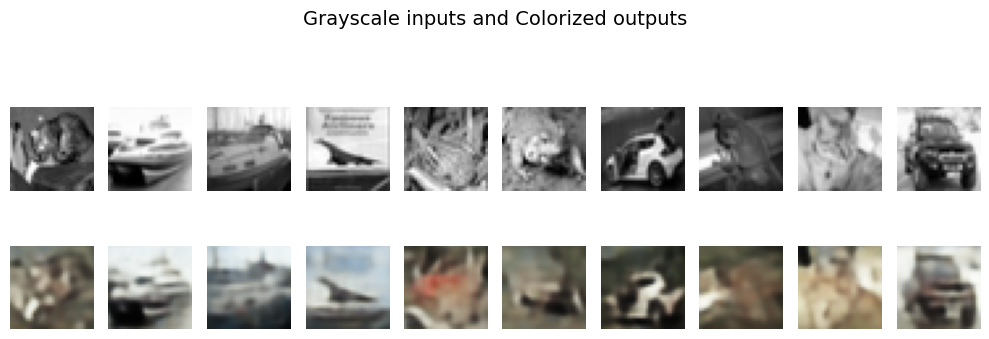

In [13]:
import matplotlib.pyplot as plt

# Ensure images are in the range [0, 1] for visualization
# np.clip is used to ensure that pixel values are within the valid range for display
# sometimes the output of the model can be outside this range
test_images = np.clip(test_images, 0, 1)
predicted_images = np.clip(predicted_images, 0, 1)

# Number of test images to display
n = test_images.shape[0]

plt.figure(figsize=(10, 4))

for i in range(n):
    # Grayscale image
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')  # squeeze для (32, 32)
    plt.axis('off')
    
    # Reconstructed color image
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_images[i])
    plt.axis('off')

plt.suptitle("Grayscale inputs and Colorized outputs", fontsize=14)
plt.tight_layout()
plt.show()